In [ ]:
pip install wordcloud -q

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# **Amazon Alexa Review - Sentiment Analysis**

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

## **Importing required libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Exploratory Data Analysis**

### **Preprocessing**

Load the data

In [ ]:
data = pd.read_csv(r"/content/amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


Visualize the first few data

In [ ]:
data.head(15)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,"""I received the echo as a gift. I needed anoth...",1
6,3,31-Jul-18,Sandstone Fabric,"""Without having a cellphone, I cannot use many...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,"""Love it! I’ve listened to songs I haven’t hea...",1


Names of the Columns

In [ ]:
print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


Check for null values

In [ ]:
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


There is one record with no 'verified_reviews' (null value)

Getting the record where 'verified_reviews' is null

In [ ]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


We will drop the null record

In [ ]:
data.dropna(inplace=True)

In [ ]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column


In [ ]:
data['length'] = data['verified_reviews'].apply(len)

In [ ]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

Randomly checking for 10th record

In [ ]:
print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [ ]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### **Analyzing 'rating' column**

This column refers to the rating of the variation given by the user

In [ ]:
len(data)

3149

Distinct values of 'rating' and its count

In [ ]:
print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


Let's plot the above values in a bar graph

Bar plot to visualize the total counts of each rating

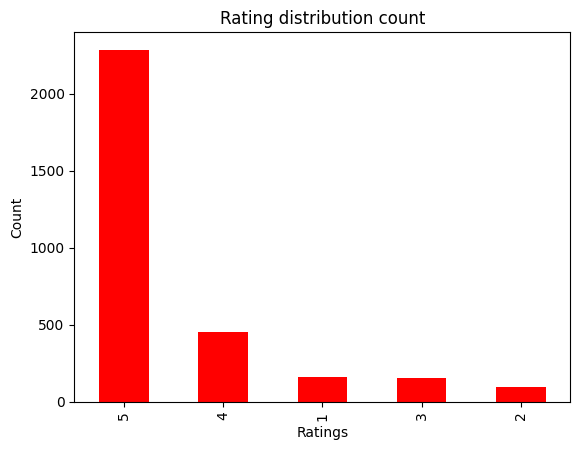

In [ ]:
data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records


In [ ]:
print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


Let's plot the above values in a pie chart

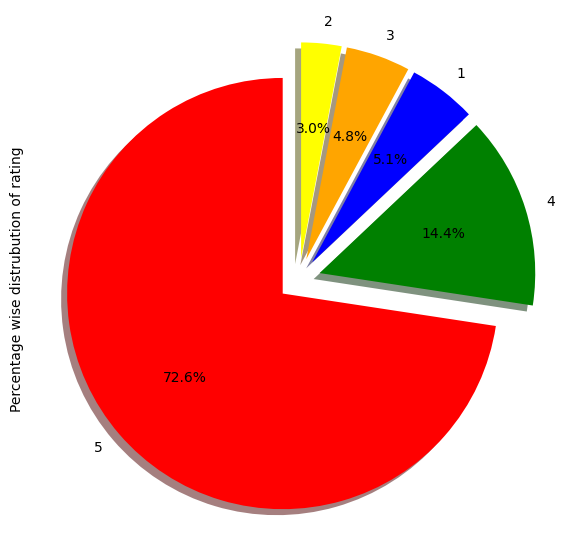

In [ ]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':0, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

plt.show()

### **Analyzing 'feedback' column**

This column refers to the feedback of the verified review

In [ ]:
#Distinct values of 'feedback' and its count

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

Extracting the 'verified_reviews' value for one record with feedback = 0

In [ ]:
review_0 = data[data['feedback'] == 0].iloc[2]['verified_reviews']
print(review_0)

Not much features.


Extracting the 'verified_reviews' value for one record with feedback = 1


In [ ]:
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

**Bar graph to visualize the total counts of each feedback**




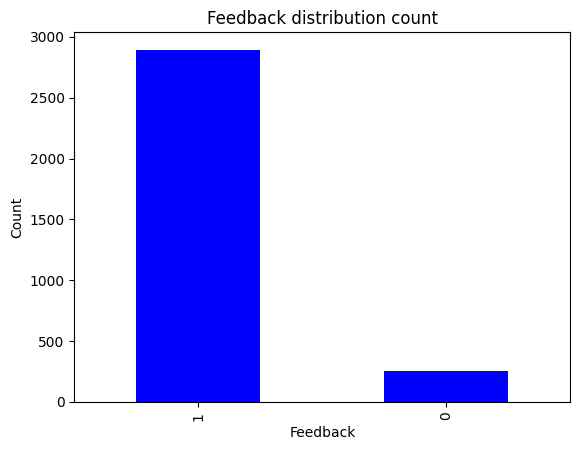

In [ ]:
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records


In [ ]:
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

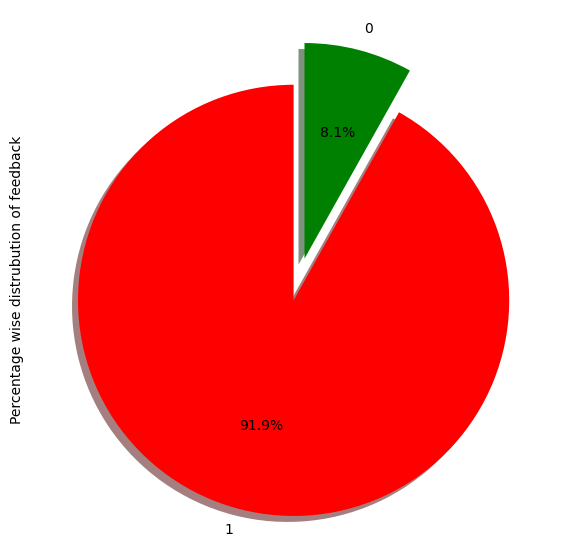

In [ ]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':0, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

**Feedback = 0**


In [ ]:
data[data['feedback'] == 0]['rating'].value_counts()

,count
rating,
1,161
2,95


**Feedback = 1**


In [ ]:
data[data['feedback'] == 1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### **Analyzing 'variation' column**

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

Distinct values of 'variation' and its count

In [ ]:
print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


Bar graph to visualize the total counts of each variation

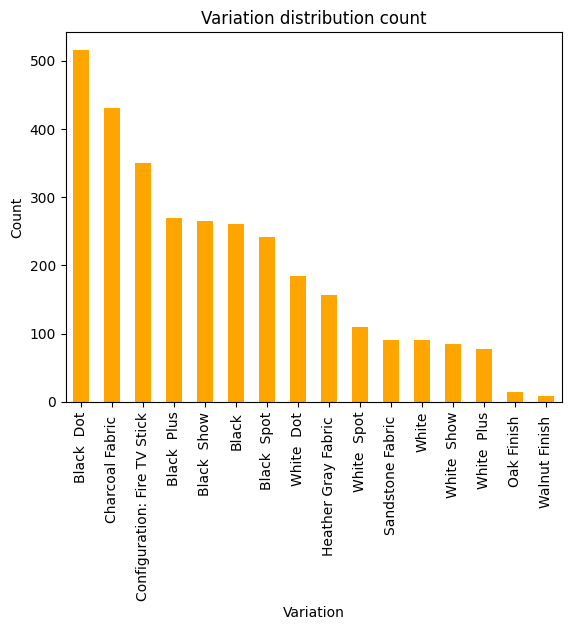

In [ ]:
data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records


In [ ]:
print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


Mean rating according to variation

In [ ]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


Let's analyze the above ratings

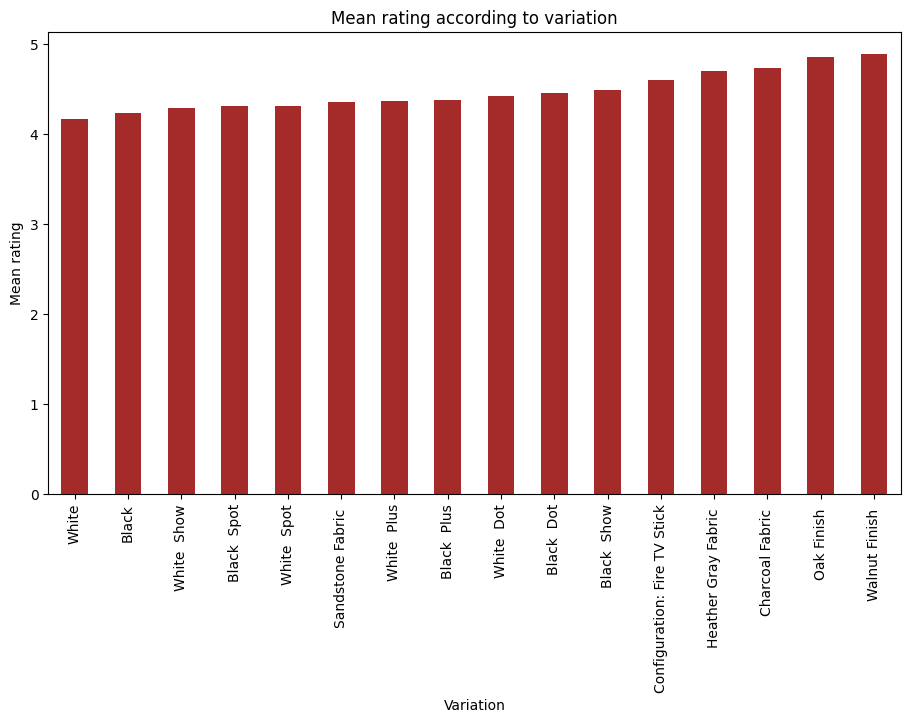

In [ ]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

### **Analyzing 'verified_reviews' column**

This column contains the textual review given by the user for a variation for the product.

In [ ]:
data['length'].describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

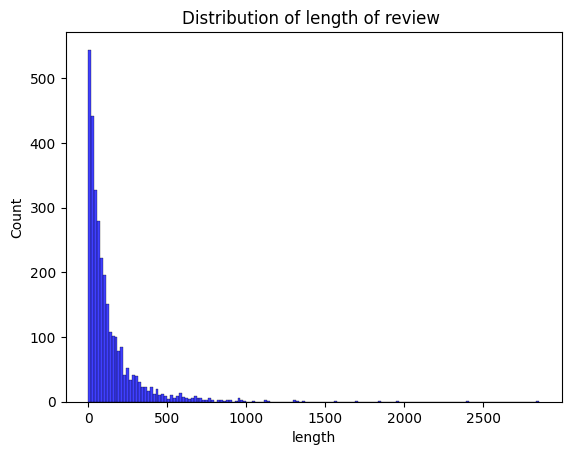

In [ ]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

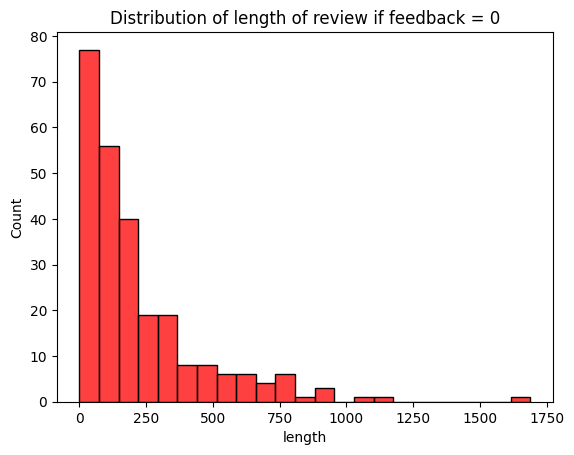

In [ ]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

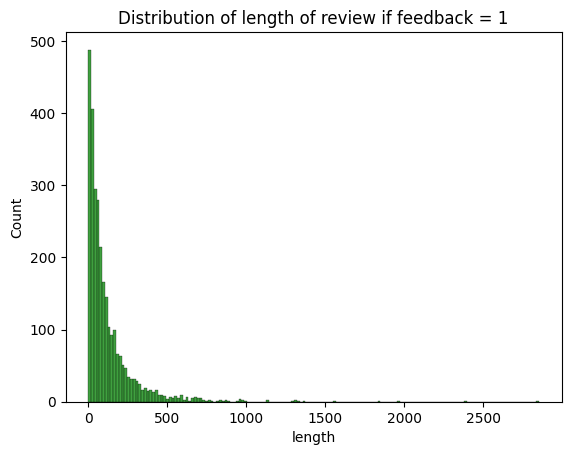

In [ ]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

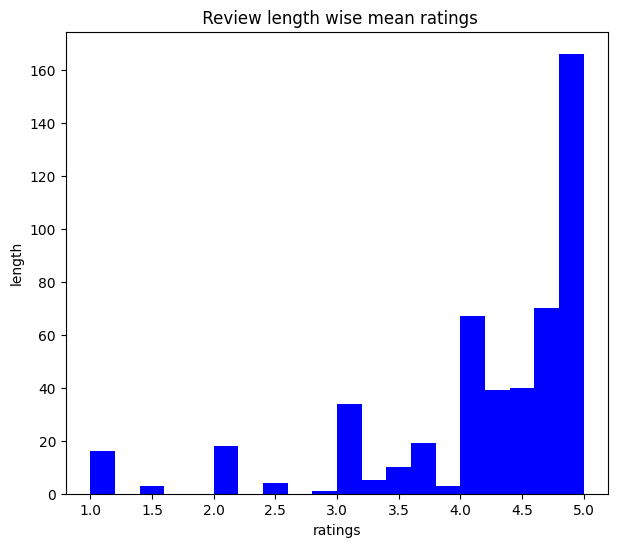

In [ ]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [ ]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

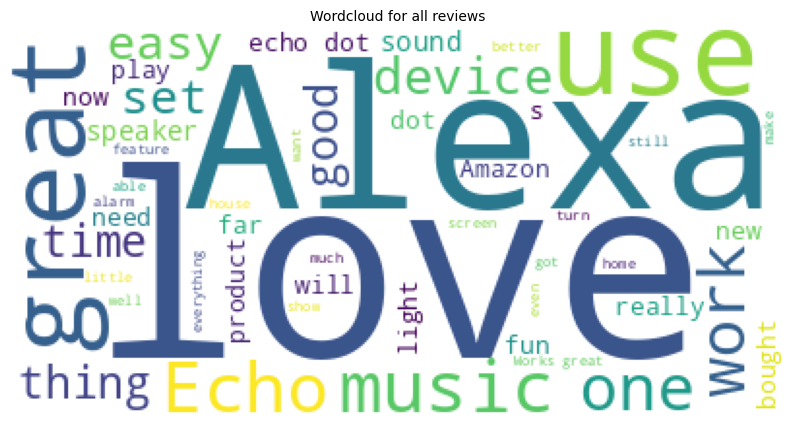

In [ ]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [ ]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


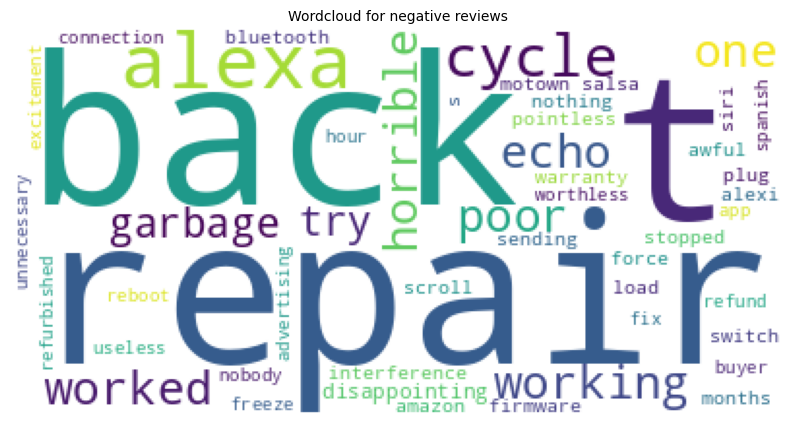

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

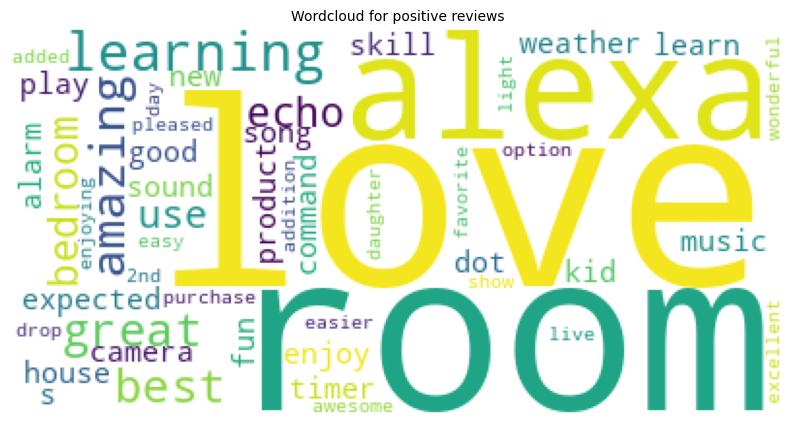

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Let's make a Machine Learning model for classifying sentences into positive or negative. We will use the new data set which is provided


**Step1: Basic Python Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

**Step2: Natural Language Processing**

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Step3: Scikit-Learn (Machine Learning Library for Python)**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

**Step4: Evaluation Metrics**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

**Dataset**

In [ ]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

df = pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)

print("Shape of the DataFrame:",df.shape)
print(df.head(5))

Shape of the DataFrame: (18000, 2)
                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


Now, we will check for the various target labels in our dataset

<Axes: xlabel='count', ylabel='label'>

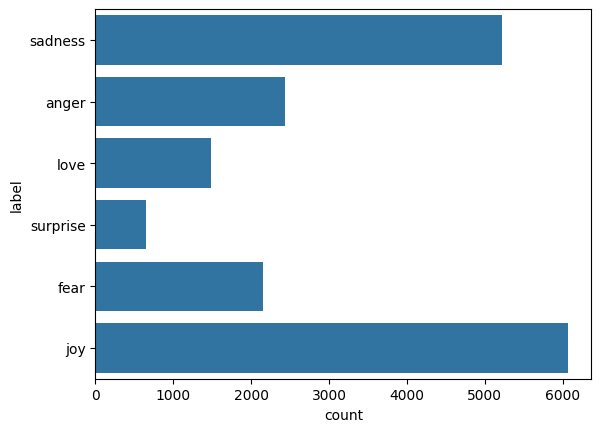

In [ ]:
sns.countplot(df.label)

As we can see that, we have 6 labels or targets in the dataset. We can make a multi-class classifier for Sentiment Analysis using NLP. But, for the sake of simplicity, we will merge these labels into two classes, i.e. Positive and Negative sentiment.
1. Positive Sentiment – “joy”,”love”,”surprise”
2. Negative Sentiment – “anger”,”sadness”,”fear”

In [ ]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [ ]:
custom_encoder(df['label'])

In [ ]:
label_counts = df['label'].value_counts()

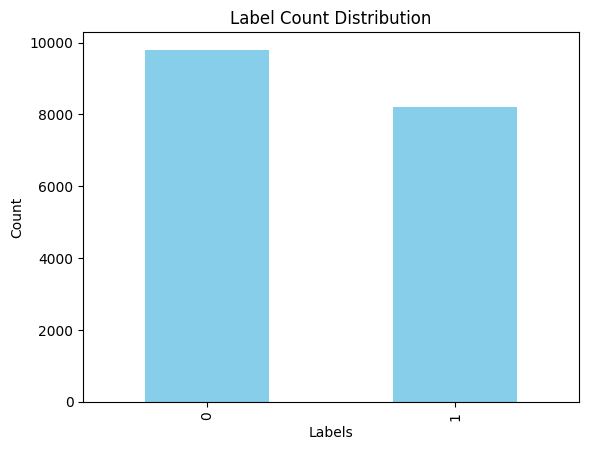

In [ ]:
label_counts.plot(kind='bar', color='skyblue')

plt.title('Label Count Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.show()

Now, we can see that our target has changed to 0 and 1,i.e. 0 for Negative and 1 for Positive, and the data is more or less in a balanced state.

**Step6: Data Pre-processing**

Now, we will perform some pre-processing on the data before converting it into vectors and passing it to the machine learning model.

We will create a function for pre-processing of data.

1. First, we will iterate through each record, and using a regular expression, we will get rid of any characters apart from alphabets.
2. Then, we will convert the string to lowercase as, the word “Good” is different from the word “good”.
3. Because, without converting to lowercase, it will cause an issue when we will create vectors of these words, as two different vectors will be created for the same word which we don’t want to.
4. Then we will check for stopwords in the data and get rid of them. Stopwords are commonly used words in a sentence such as “the”, “an”, “to” etc. which do not add much value.
5. Then, we will perform lemmatization on each word,i.e. change the different forms of a word into a single item called a lemma.

A lemma is a base form of a word. For example, “run”, “running” and “runs” are all forms of the same lexeme, where the “run” is the lemma. Hence, we are converting all occurrences of the same lexeme to their respective lemma. And, then return a corpus of processed data.

In [ ]:
#object of WordNetLemmatizer
lm = WordNetLemmatizer()

In [ ]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [ ]:
corpus = text_transformation(df['text'])

Now, we will create a Word Cloud. It is a data visualization technique used to depict text in such a way that, the more frequent words appear enlarged as compared to less frequent words. This gives us a little insight into, how the data looks after being processed through all the steps until now.

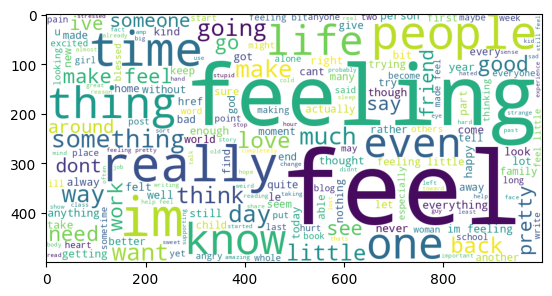

In [ ]:
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

**Step7: Bag of Words**

Now, we will use the Bag of Words Model(BOW), which is used to represent the text in the form of a bag of words ,i.e. the grammar and the order of words in a sentence are not given any importance, instead, multiplicity, i.e. (the number of times a word occurs in a document) is the main point of concern.

Basically, it describes the total occurrence of words within a document.

In [ ]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)
X = traindata
y = df.label

Ngram is a sequence of ‘n’ of words in a row or sentence. ‘ngram_range’ is a parameter, which we use to give importance to the combination of words, such as, “social media” has a different meaning than “social” and “media” separately.

We can experiment with the value of the ngram_range parameter and select the option which gives better results.

I’m going to use Random Forest Classifier, and we will tune the hyperparameters using GridSearchCV.

In [ ]:
rfc = RandomForestClassifier(max_features='sqrt',
                             max_depth=None,
                             n_estimators=500,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             bootstrap=True)
rfc.fit(X,y)

RandomForestClassifier(min_samples_split=5, n_estimators=500)

**Step8: Test Data Transformation**

Now, we will read the test data and perform the same transformations we did on training data and finally evaluate the model on its predictions.

In [ ]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])

In [ ]:
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = rfc.predict(testdata)

**Step9: Model Evaluation**

We will evaluate our model using various metrics such as Accuracy Score, Precision Score, Recall Score, Confusion Matrix and create a roc curve to visualize how our model performed.

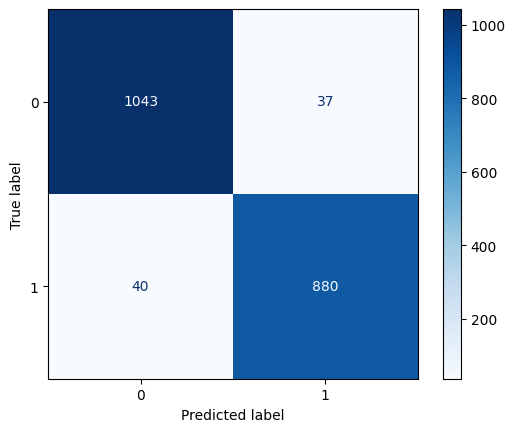

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
acc_score = accuracy_score(y_test, predictions)
pre_score = precision_score(y_test, predictions)
rec_score = recall_score(y_test, predictions)

print('Accuracy_score: ', acc_score)
print('Precision_score: ', pre_score)
print('Recall_score: ', rec_score)
print("-" * 50)

Accuracy_score:  0.9615
Precision_score:  0.9596510359869138
Recall_score:  0.9565217391304348
--------------------------------------------------


**Finaly Predict for Custom Input**

In [ ]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [ ]:
# function to take the input statement and perform the same transformations we did earlier
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rfc.predict(transformed_input)
    expression_check(prediction)

In [ ]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]

In [ ]:
sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has Negative Sentiment.
Input statement has Positive Sentiment.
